# Visualize HDF5 outputs from GADGET-2 - Galaxy rotation simulation

In [1]:
import os
import h5py
import numpy as np

from scipy.interpolate import interpn

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize 
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

In [2]:
path = '/home/masterdesky/GADGET2/Simulations/galaxy_single_no_dm/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [3]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Load HDF5 snapshots

In [4]:
snapshots = [f for f in os.listdir(path) if 'snapshot' in f]
snapshots.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

### Loading coordinates

In [5]:
sf = h5py.File(path + snapshots[0], 'r')

In [6]:
list(sf)

['Header', 'PartType0', 'PartType1', 'PartType2', 'PartType3']

#### Meaning of particle types in this case:

- PartType0 : Disk
- PartType1 : Halo
- PartType2 : Gas
- PartType3 : Bulge

In [7]:
xyz_0 = np.array(list(sf['PartType0']['Coordinates']))
xyz_1 = np.array(list(sf['PartType1']['Coordinates']))
xyz_2 = np.array(list(sf['PartType2']['Coordinates']))
xyz_3 = np.array(list(sf['PartType3']['Coordinates']))

v_xyz_0 = np.array(list(sf['PartType0']['Velocities']))
v_xyz_1 = np.array(list(sf['PartType1']['Velocities']))
v_xyz_2 = np.array(list(sf['PartType2']['Velocities']))
v_xyz_3 = np.array(list(sf['PartType3']['Velocities']))

In [8]:
xyz = np.concatenate((xyz_0,
                      #xyz_1,
                      xyz_2,
                      xyz_3))
v_xyz = np.concatenate((v_xyz_0,
                        #v_xyz_1,
                        v_xyz_2,
                        v_xyz_3))

### Calculating densities of points

In [9]:
def density_scatter(x, y, sort=True, bins=[20,20]):
    """
    Scatter plot colored by 2d histogram
    """
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    c = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                data , np.vstack([x,y]).T,
                method='splinef2d', bounds_error=False)

    # To be sure to plot all data
    c[np.where(np.isnan(c))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = c.argsort()
        x, y, c = x[idx], y[idx], c[idx]

    return np.vstack([x,y]).T, c

In [10]:
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]
data_1, c_1 = density_scatter(x, y, sort=True, bins=[50,50]) # XY
data_2, c_2 = density_scatter(x, z, sort=True, bins=[50,50]) # XZ
data_3, c_3 = density_scatter(y, z, sort=True, bins=[50,50]) # YZ

### Visualize loaded HDF5 snapshots

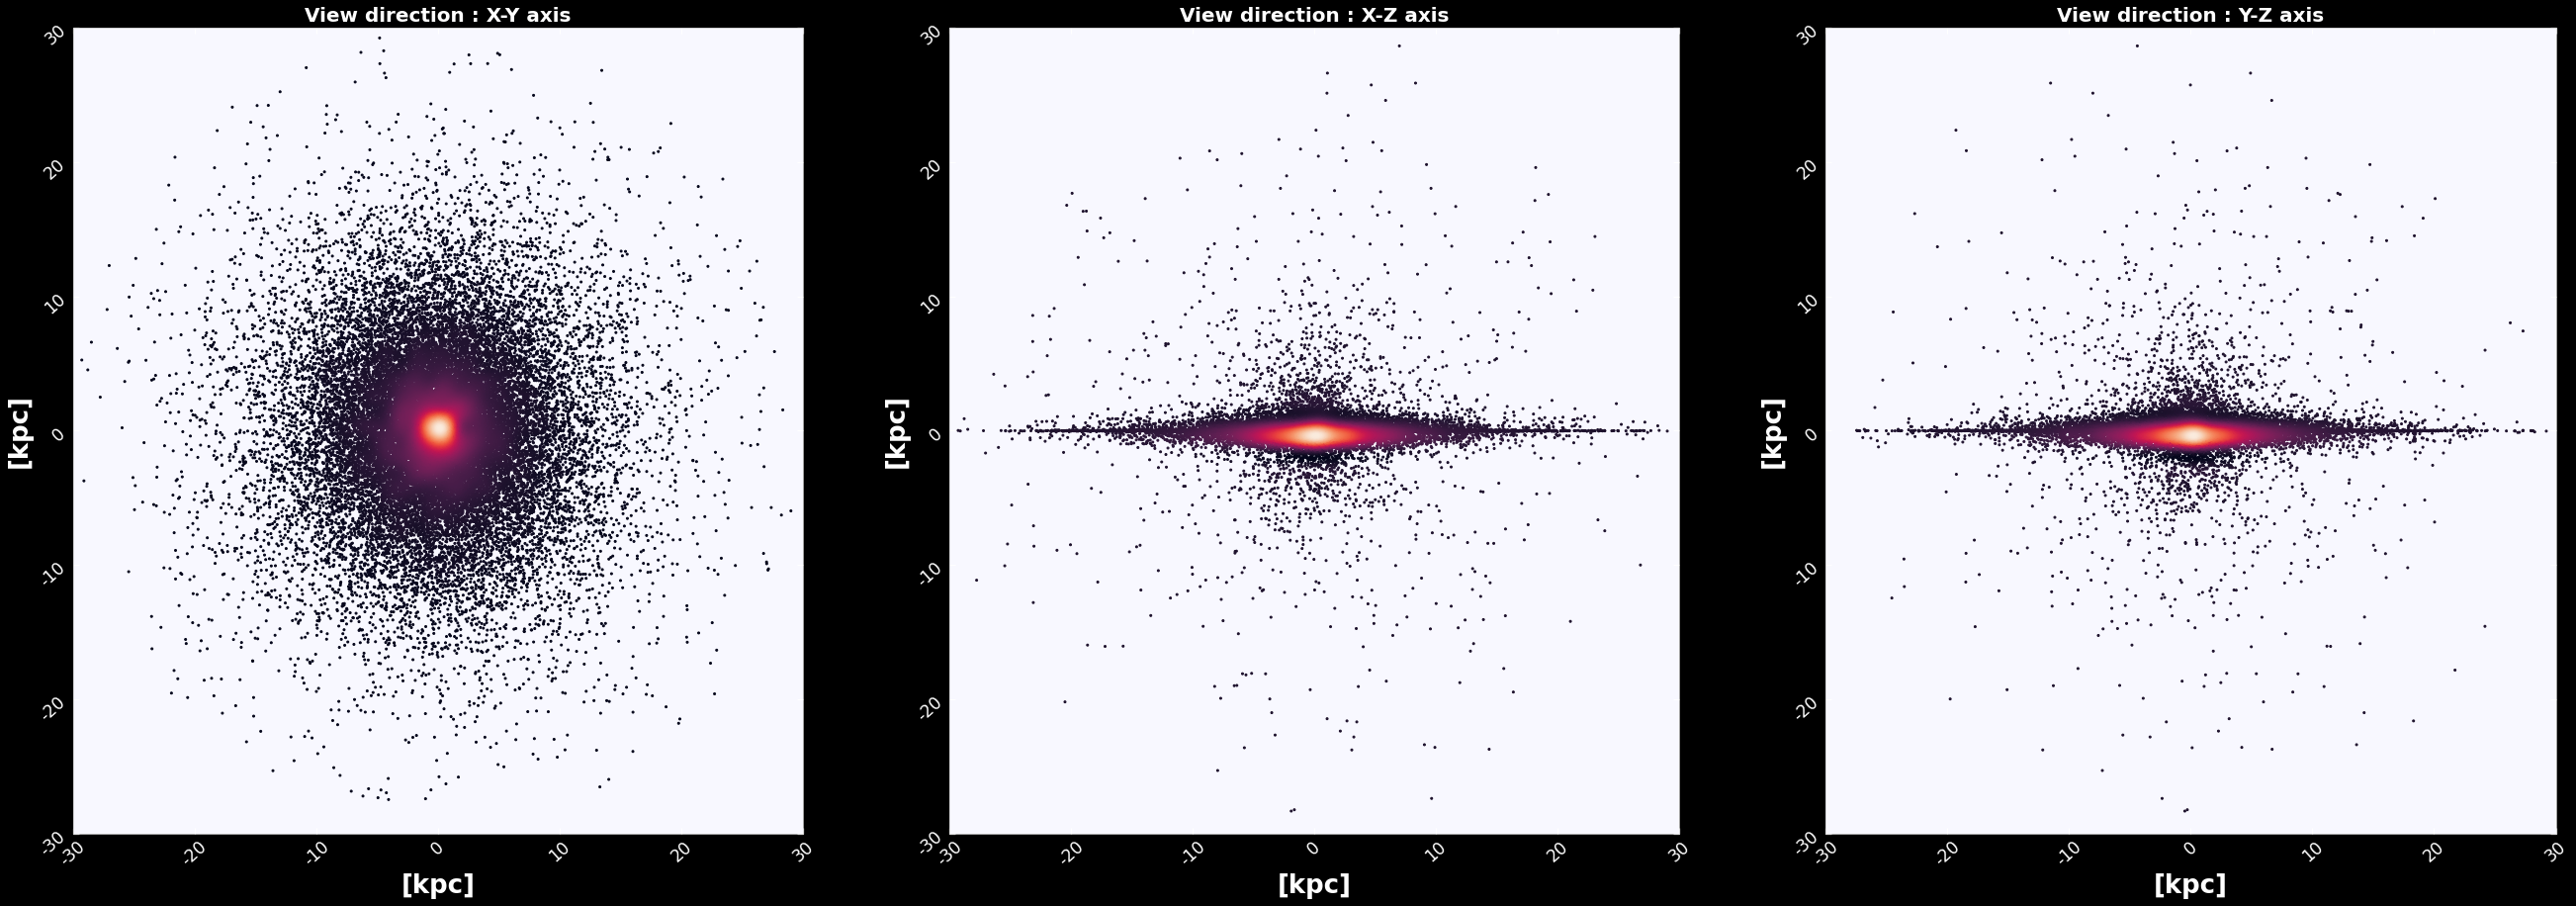

In [22]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*15, nrows*15),
                         facecolor='black', subplot_kw={'facecolor' : 'ghostwhite'})
sc = 2

for i, (v, c) in enumerate(zip([data_1, data_2, data_3],
                          [c_1, c_2, c_3])):
    
    axes[i].scatter(v[:,0], v[:,1], c=c, s=sc**2)
    
    # Set axis limits
    axes[i].set_xlim(-30, 30)
    axes[i].set_ylim(-30, 30)
    # Set ticklabels
    x_ticks = np.linspace(-30, 30, 7).astype(int)
    y_ticks = np.linspace(-30, 30, 7).astype(int)
    axes[i].set_xticks(x_ticks)
    axes[i].set_xticklabels(x_ticks, rotation=42)
    axes[i].set_yticks(y_ticks)
    axes[i].set_yticklabels(y_ticks, rotation=42)

# Set axes ticks and labels
view = [('X','Y'), ('X','Z'), ('Y','Z')]
for k, ax in enumerate(axes):
    ax.grid(False)
    ax.set_title('View direction : {0}-{1} axis'.format(view[k][0], view[k][1]),
                 fontsize=axistitlesize, fontweight='bold', color='white')
    ax.set_xlabel('[kpc]', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('[kpc]', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

plt.savefig('./output/galaxy_init.png',
            format='png',
            dpi=200,
            bbox_inches='tight')
    
plt.show()

## 2. Animate HDF5 snapshots

### 2.1. Mayavi version

In [68]:
from scipy import stats
from mayavi import mlab

In [18]:
# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=5e-1)
axes = mlab.axes(x_axis_visibility=False, y_axis_visibility=False, z_axis_visibility=False)

#mlab.xlabel('X [kly]')
#mlab.ylabel('Y [kly]')
#mlab.zlabel('Z [kly]')

mlab.show()

In [8]:
# Load the first set of coordinates
sf = h5py.File(path + snapshots[0], 'r')
xyz = np.array(list(sf['PartType2']['Coordinates']))
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]
# Calculate densities
mu, sigma = 0, 0.1
xyz_kde = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz_kde)
density = kde(xyz_kde)
# Plot the first frame
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=5e-1)

@mlab.animate(delay=33)
def anim():
    fig = mlab.figure('DensityPlot')
    axes = mlab.axes(x_axis_visibility=False, y_axis_visibility=False, z_axis_visibility=False)
    while True:
        for sf in snapshots[1:]:
            sf = h5py.File(path + sf, 'r')
            xyz = np.array(list(sf['PartType2']['Coordinates']))
            x = xyz[:, 0]
            y = xyz[:, 1]
            z = xyz[:, 2]
            xyz_kde = np.vstack([x,y,z])
            kde = stats.gaussian_kde(xyz_kde)
            density = kde(xyz_kde)
            #print('Updating scene...')
            pts.mlab_source.set(x=x, y=y, z=z, scalars=density)
            #fig.scene.render()
            yield

anim()
mlab.show()

### 2.2. Custom FFMPEG animation

In [6]:
class AnimatedCollision(object):
    """
    An animated scatter plot using matplotlib.animations.FuncAnimation.
    Based on : https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
    """
    def __init__(self, snapshots, fps):
        self.snapshots = snapshots
        self.n_snapshots = len(snapshots)
        self.fps = fps

        self.nrows = 1
        self.ncols = 3        
        self.fig, self.axes = plt.subplots(self.nrows, self.ncols, figsize=(self.ncols*12, self.nrows*12),
                                           facecolor='black', subplot_kw={'facecolor' : 'ghostwhite'})
        self.sc = 2
        # Setup `matplotlib`'s FuncAnimation
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=1000/self.fps, frames=self.n_snapshots,
                                           init_func=self.setup_plot, blit=True, )
        
        # Set up formatting for the movie files
        self.Writer = animation.writers['ffmpeg']
        self.writer = self.Writer(fps=self.fps, metadata=dict(artist='BalageP'), bitrate=24000)

    def setup_plot(self):
        """
        Initial drawing of the scatter plot.
        """
        data_1, data_2, data_3, c_1, c_2, c_3 = next(self.data_stream(0))
        self.scat_0 = self.axes[0].scatter([], [], c=[], s=self.sc**2)
        self.scat_1 = self.axes[1].scatter([], [], c=[], s=self.sc**2)
        self.scat_2 = self.axes[2].scatter([], [], c=[], s=self.sc**2)
        
        for i, v in enumerate([data_1, data_2, data_3]):
            # Set axis limits
            self.axes[i].set_xlim(-30, 30)
            self.axes[i].set_ylim(-30, 30)
            # Set ticklabels
            x_ticks = np.linspace(-30, 30, 7).astype(int)
            y_ticks = np.linspace(-30, 30, 7).astype(int)
            self.axes[i].set_xticks(x_ticks)
            self.axes[i].set_xticklabels(x_ticks, rotation=42)
            self.axes[i].set_yticks(y_ticks)
            self.axes[i].set_yticklabels(y_ticks, rotation=42)

        # Set axes ticks and labels
        view = [('X','Y'), ('X','Z'), ('Y','Z')]
        for k, ax in enumerate(self.axes):
            ax.grid(False)
            ax.set_title('View direction : {0}-{1} axis'.format(view[k][0], view[k][1]),
                         fontsize=axistitlesize, fontweight='bold', color='white')
            ax.set_xlabel('[kpc]', fontsize=axislabelsize, fontweight='bold', color='white')
            ax.set_ylabel('[kpc]', fontsize=axislabelsize, fontweight='bold', color='white')
            ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
        
        # For FuncAnimation's sake, we need to return the artist we'll be using.
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat_0, self.scat_1, self.scat_2,

    def density_scatter(self, x, y, sort=True, bins=[20,20]):
        """
        Scatter plot colored by 2d histogram
        """
        data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
        c = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                    data , np.vstack([x,y]).T,
                    method='splinef2d', bounds_error=False)

        # To be sure to plot all data
        c[np.where(np.isnan(c))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        if sort :
            idx = c.argsort()
            x, y, c = x[idx], y[idx], c[idx]

        return np.vstack([x,y]).T, c
    
    def data_stream(self, i):
        """
        Load states of the galaxies from the HDF5 files on the run to save memory.
        """
        while True:
            ## Load plotted data (Leave halo out)
            sf = h5py.File(path + self.snapshots[i], 'r')
            xyz_0 = np.array(list(sf['PartType0']['Coordinates']))
            #xyz_1 = np.array(list(sf['PartType1']['Coordinates']))
            xyz_2 = np.array(list(sf['PartType2']['Coordinates']))
            xyz_3 = np.array(list(sf['PartType3']['Coordinates']))
    
            ## Preprocess data
            xyz = np.concatenate((xyz_0, xyz_2, xyz_3))
            xyz -= xyz.mean(axis=0)
            x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
            data_1, c_1 = self.density_scatter(x, y, sort=True, bins=[50,50]) # XY
            data_2, c_2 = self.density_scatter(x, z, sort=True, bins=[50,50]) # XZ
            data_3, c_3 = self.density_scatter(y, z, sort=True, bins=[50,50]) # YZ
            yield data_1, data_2, data_3, c_1, c_2, c_3

    def update(self, i):
        """
        Update the scatter plot.
        """
        data_1, data_2, data_3, c_1, c_2, c_3 = next(self.data_stream(i))

        # Set data
        self.scat_0.set_offsets(data_1)
        self.scat_1.set_offsets(data_2)
        self.scat_2.set_offsets(data_3)
        
        # Set colors for data
        self.scat_0.set_array(c_1)
        self.scat_1.set_array(c_2)
        self.scat_2.set_array(c_3)

        # We need to return the updated artist for FuncAnimation to draw.
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat_0, self.scat_1, self.scat_2,

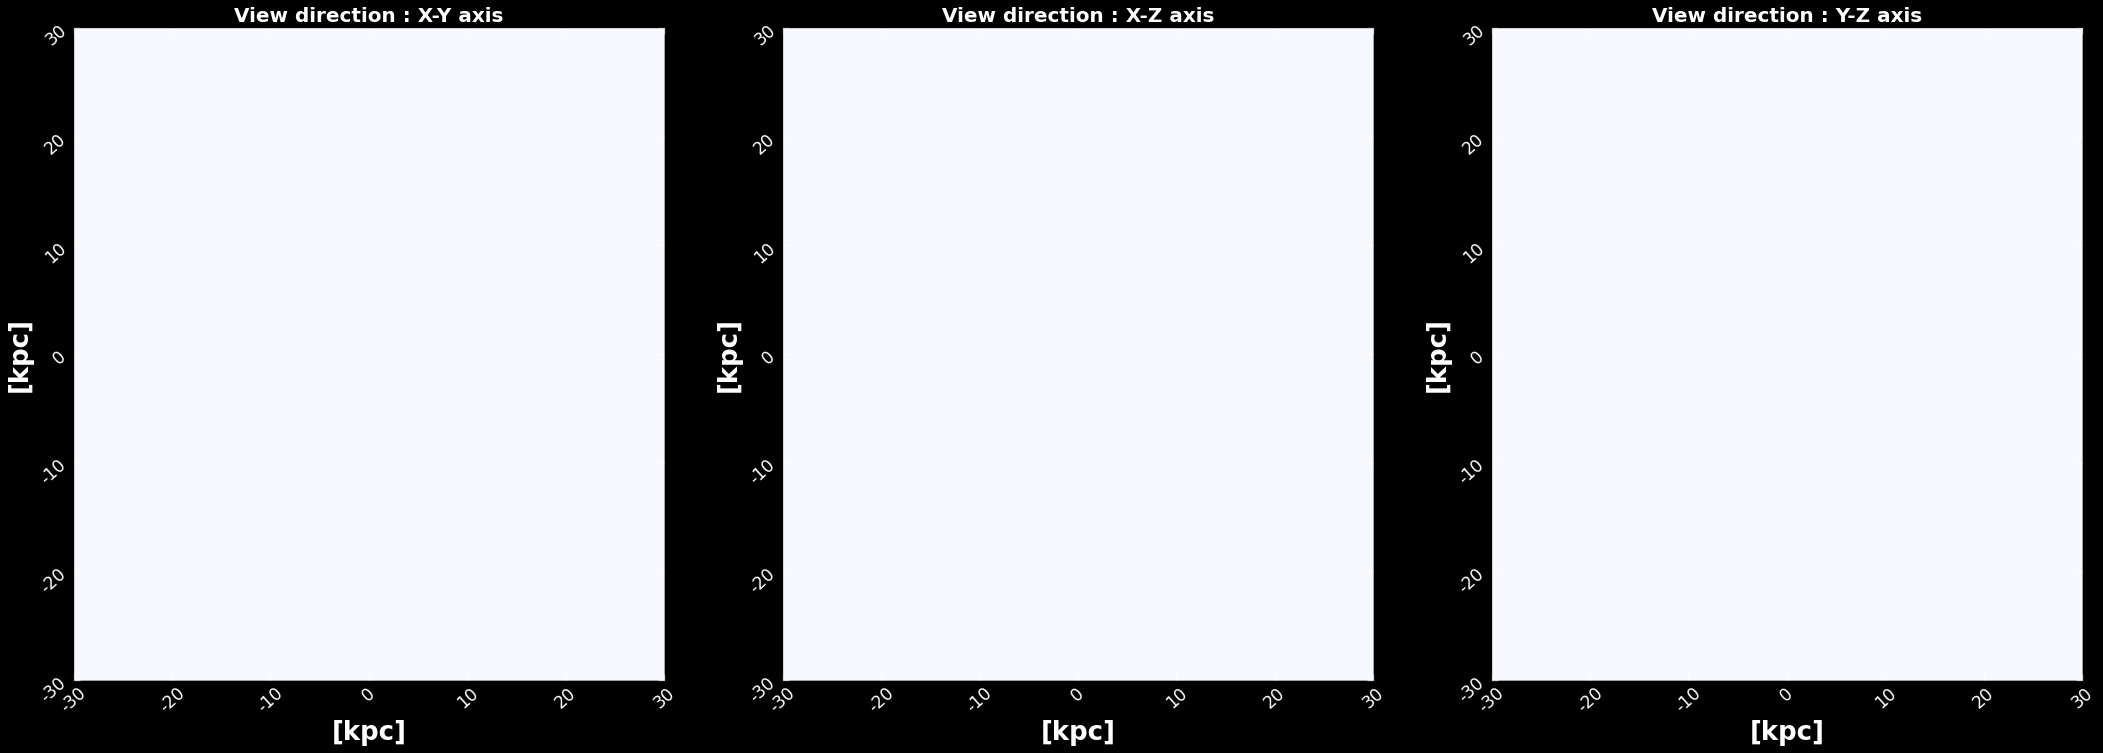

In [7]:
a = AnimatedCollision(snapshots, fps=30)

In [8]:
%%time
a.ani.save('galaxy_rotation_full_galaxy_no_dark_matter_30fps.mp4', writer=a.writer)

CPU times: user 2h 41min 54s, sys: 31.8 s, total: 2h 42min 26s
Wall time: 2h 42min 23s


## 3. Determine velocity profile

### Loading velocities

In [5]:
sf = h5py.File(path + snapshots[0], 'r')

In [152]:
list(sf)

['Header', 'PartType0', 'PartType1', 'PartType2', 'PartType3']

In [153]:
print(list(sf['PartType0']))
print(list(sf['PartType1']))
print(list(sf['PartType2']))
print(list(sf['PartType3']))

['Coordinates', 'Density', 'InternalEnergy', 'Masses', 'ParticleIDs', 'SmoothingLength', 'Velocities']
['Coordinates', 'Masses', 'ParticleIDs', 'Velocities']
['Coordinates', 'Masses', 'ParticleIDs', 'Velocities']
['Coordinates', 'Masses', 'ParticleIDs', 'Velocities']


#### Meaning of particle types in this case:

- PartType0 : Disk
- PartType1 : Halo
- PartType2 : Gas
- PartType3 : Bulge

In [154]:
xyz_0 = np.array(list(sf['PartType0']['Coordinates']))
xyz_1 = np.array(list(sf['PartType1']['Coordinates']))
xyz_2 = np.array(list(sf['PartType2']['Coordinates']))
xyz_3 = np.array(list(sf['PartType3']['Coordinates']))

v_xyz_0 = np.array(list(sf['PartType0']['Velocities']))
v_xyz_1 = np.array(list(sf['PartType1']['Velocities']))
v_xyz_2 = np.array(list(sf['PartType2']['Velocities']))
v_xyz_3 = np.array(list(sf['PartType3']['Velocities']))

In [155]:
def center_values(xyz):

    xyz -= xyz.mean(axis=0)
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    r = np.sqrt((xyz**2).sum(axis=1))
    
    return x, y, z, r

In [156]:
# Type0 : Disk
x_0, y_0, z_0, r_0 = center_values(xyz_0)
v_x_0, v_y_0, v_z_0, v_r_0 = center_values(v_xyz_0)

# Type1 : Halo
x_1, y_1, z_1, r_1 = center_values(xyz_1)
v_x_1, v_y_1, v_z_1, v_r_1 = center_values(v_xyz_1)

# Type2 : Bulge
x_2, y_2, z_2, r_2 = center_values(xyz_2)
v_x_2, v_y_2, v_z_2, v_r_2 = center_values(v_xyz_2)

# Type3 : Gas
x_3, y_3, z_3, r_3 = center_values(xyz_3)
v_x_3, v_y_3, v_z_3, v_r_3 = center_values(v_xyz_3)

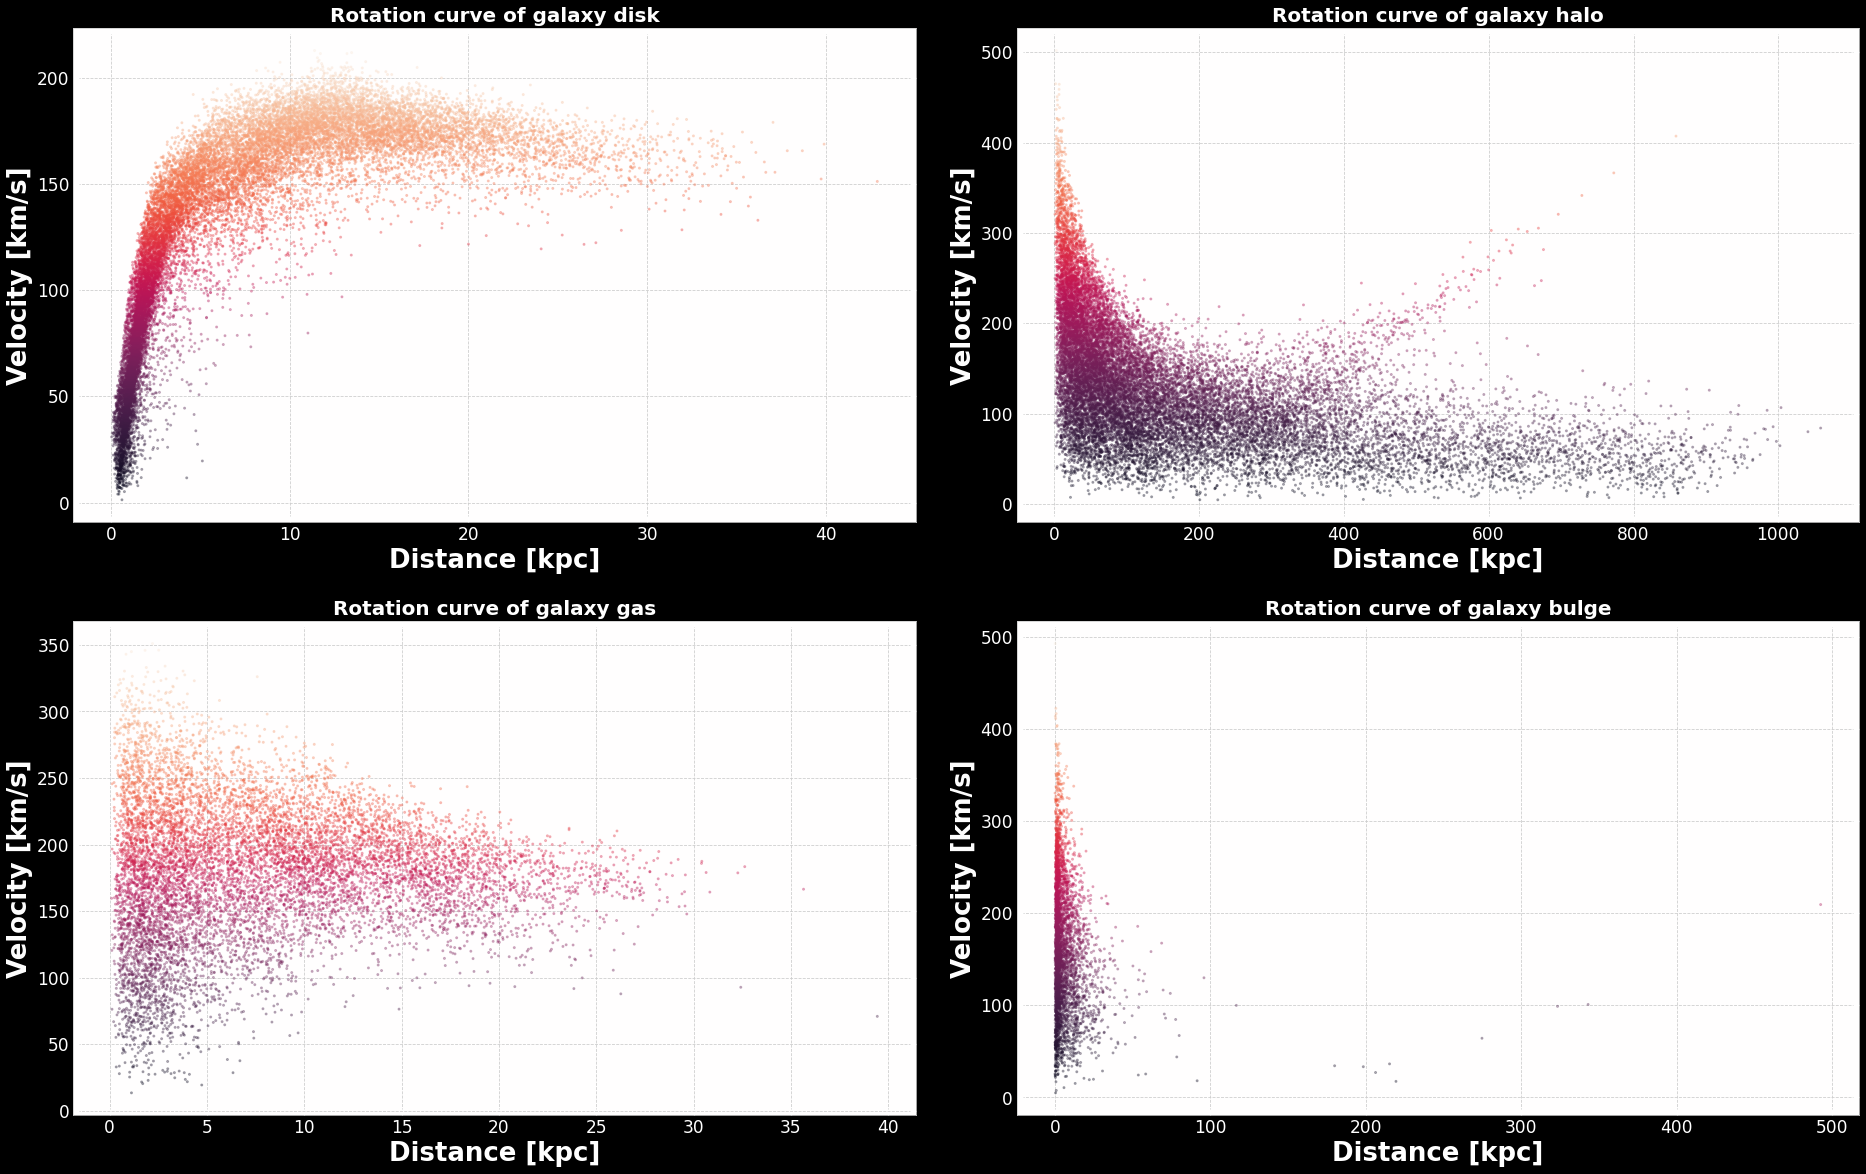

In [157]:
nrows = 2
ncols = 2
fig_color = 'black'
subplot_color = '#FFFEFE'
text_color = 'white'
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*16, nrows*10),
                         facecolor=fig_color, subplot_kw={'facecolor' : subplot_color})
fig.subplots_adjust(wspace=0.12)
sc = 2


# Type0 : Disk
ax = axes.reshape(-1)[0]
ax.set_title('Rotation curve of galaxy disk', fontsize=axistitlesize, fontweight='bold',
             color=text_color)
ax.scatter(r_0, v_r_0,
           c=v_r_0, s=sc**2, alpha=0.3)

# Type1 : Halo
ax = axes.reshape(-1)[1]
ax.set_title('Rotation curve of galaxy halo', fontsize=axistitlesize, fontweight='bold',
             color=text_color)
ax.scatter(r_1, v_r_1,
           c=v_r_1, s=sc**2, alpha=0.3)

# Type2 : Bulge
ax = axes.reshape(-1)[2]
ax.set_title('Rotation curve of galaxy gas', fontsize=axistitlesize, fontweight='bold',
             color=text_color)
ax.scatter(r_2, v_r_2,
           c=v_r_2, s=sc**2, alpha=0.3)

# Type3 : Gas
ax = axes.reshape(-1)[3]
ax.set_title('Rotation curve of galaxy bulge', fontsize=axistitlesize, fontweight='bold',
             color=text_color)
ax.scatter(r_3, v_r_3,
           c=v_r_3, s=sc**2, alpha=0.3)

for ax in axes.reshape(-1):
    ax.set_xlabel('Distance [kpc]', fontsize=axislabelsize, fontweight='bold',
                  color=text_color)
    ax.set_ylabel('Velocity [km/s]', fontsize=axislabelsize, fontweight='bold',
                  color=text_color)
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors=text_color)

plt.show()

## 4. Animate rotation profiles

In [10]:
class AnimeteRotationProfile(object):
    """
    An animated scatter plot using matplotlib.animations.FuncAnimation.
    Based on : https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
    """
    def __init__(self, snapshots, fps):
        self.snapshots = snapshots
        self.n_snapshots = len(snapshots)
        self.fps = fps

        self.nrows = 2
        self.ncols = 2        
        self.fig, self.axes = plt.subplots(self.nrows, self.ncols, figsize=(self.ncols*16, self.nrows*10),
                                           facecolor='black', subplot_kw={'facecolor' : 'ghostwhite'})
        self.fig.subplots_adjust(wspace=0.12)
        self.sc = 2
        self.alpha = 0.3
        self.text_color = 'white'
        # Setup `matplotlib`'s FuncAnimation
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=1000/self.fps, frames=self.n_snapshots,
                                           init_func=self.setup_plot, blit=True, )
        
        # Set up formatting for the movie files
        self.Writer = animation.writers['ffmpeg']
        self.writer = self.Writer(fps=self.fps, metadata=dict(artist='BalageP'), bitrate=24000)

    def setup_plot(self):
        """
        Initial drawing of the scatter plot.
        """
        r_0, v_r_0, r_1, v_r_1,\
        r_2, v_r_2, r_3, v_r_3 = next(self.data_stream(0))
        
        # Type0 : Disk
        ax = self.axes.reshape(-1)[0]
        ax.set_title('Rotation curve of galaxy disk', fontsize=axistitlesize, fontweight='bold',
                     color=self.text_color)
        self.scat_0 = ax.scatter([], [],
                                 c=[], s=self.sc**2, alpha=self.alpha)

        # Type1 : Halo
        ax = self.axes.reshape(-1)[1]
        ax.set_title('Rotation curve of galaxy halo', fontsize=axistitlesize, fontweight='bold',
                     color=self.text_color)
        self.scat_1 = ax.scatter([], [],
                                 c=[], s=self.sc**2, alpha=self.alpha)
        
        # Type2 : Bulge
        ax = self.axes.reshape(-1)[2]
        ax.set_title('Rotation curve of galaxy gas', fontsize=axistitlesize, fontweight='bold',
                     color=self.text_color)
        self.scat_2 = ax.scatter([], [],
                                 c=[], s=self.sc**2, alpha=self.alpha)

        # Type3 : Gas
        ax = self.axes.reshape(-1)[3]
        ax.set_title('Rotation curve of galaxy bulge', fontsize=axistitlesize, fontweight='bold',
                     color=self.text_color)
        self.scat_3 = ax.scatter([], [],
                                 c=[], s=self.sc**2, alpha=self.alpha)
        
        # Set ax limits in the most compact way I managed at 1 AM
        for i, xy in enumerate(zip([r_0, r_1, r_2, r_3],
                                   [v_r_0, v_r_1, v_r_2, v_r_3])):
            ax = self.axes.reshape(-1)[i]
            for (var, f) in zip([xy[0], xy[1]],
                                [ax.set_xlim, ax.set_ylim]):
                _min, _max = var.min(), var.max()
                _pad = (_max - _min) / 20
                f(_min - _pad, _max + _pad)
        
        # Set axes ticks and labels
        for ax in self.axes.reshape(-1):
            ax.set_xlabel('Distance [kpc]', fontsize=axislabelsize, fontweight='bold',
                          color=self.text_color)
            ax.set_ylabel('Velocity [km/s]', fontsize=axislabelsize, fontweight='bold',
                          color=self.text_color)
            ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                           colors=self.text_color)
        
        # For FuncAnimation's sake, we need to return the artist we'll be using.
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat_0, self.scat_1, self.scat_2, self.scat_3
    
    def _center_values(self, xyz):
        xyz -= xyz.mean(axis=0)
        return np.sqrt((xyz**2).sum(axis=1))
    
    def data_stream(self, i):
        """
        Load states of the galaxies from the HDF5 files on the run to save memory.
        """
        while True:
            ## Load plotted data
            sf = h5py.File(path + self.snapshots[i], 'r')
            xyz_0 = np.array(list(sf['PartType0']['Coordinates']))
            xyz_1 = np.array(list(sf['PartType1']['Coordinates']))
            xyz_2 = np.array(list(sf['PartType2']['Coordinates']))
            xyz_3 = np.array(list(sf['PartType3']['Coordinates']))
            v_xyz_0 = np.array(list(sf['PartType0']['Velocities']))
            v_xyz_1 = np.array(list(sf['PartType1']['Velocities']))
            v_xyz_2 = np.array(list(sf['PartType2']['Velocities']))
            v_xyz_3 = np.array(list(sf['PartType3']['Velocities']))
            
            ## Preprocess loaded data
            # Type0 : Disk
            r_0 = self._center_values(xyz_0)
            v_r_0 = self._center_values(v_xyz_0)
            # Type1 : Halo
            r_1 = self._center_values(xyz_1)
            v_r_1 = self._center_values(v_xyz_1)
            # Type2 : Bulge
            r_2 = self._center_values(xyz_2)
            v_r_2 = self._center_values(v_xyz_2)
            # Type3 : Gas
            r_3 = self._center_values(xyz_3)
            v_r_3 = self._center_values(v_xyz_3)
            
            yield (r_0, v_r_0, r_1, v_r_1,
                   r_2, v_r_2, r_3, v_r_3)

    def update(self, i):
        """
        Update the scatter plot.
        """
        r_0, v_r_0, r_1, v_r_1,\
        r_2, v_r_2, r_3, v_r_3 = next(self.data_stream(i))

        # Set data
        self.scat_0.set_offsets(np.vstack([r_0,v_r_0]).T)
        self.scat_1.set_offsets(np.vstack([r_1,v_r_1]).T)
        self.scat_2.set_offsets(np.vstack([r_2,v_r_2]).T)
        self.scat_3.set_offsets(np.vstack([r_3,v_r_3]).T)
        
        # Set colors for data
        self.scat_0.set_array(v_r_0)
        self.scat_1.set_array(v_r_1)
        self.scat_2.set_array(v_r_2)
        self.scat_3.set_array(v_r_3)

        # We need to return the updated artist for FuncAnimation to draw.
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat_0, self.scat_1, self.scat_2, self.scat_3,

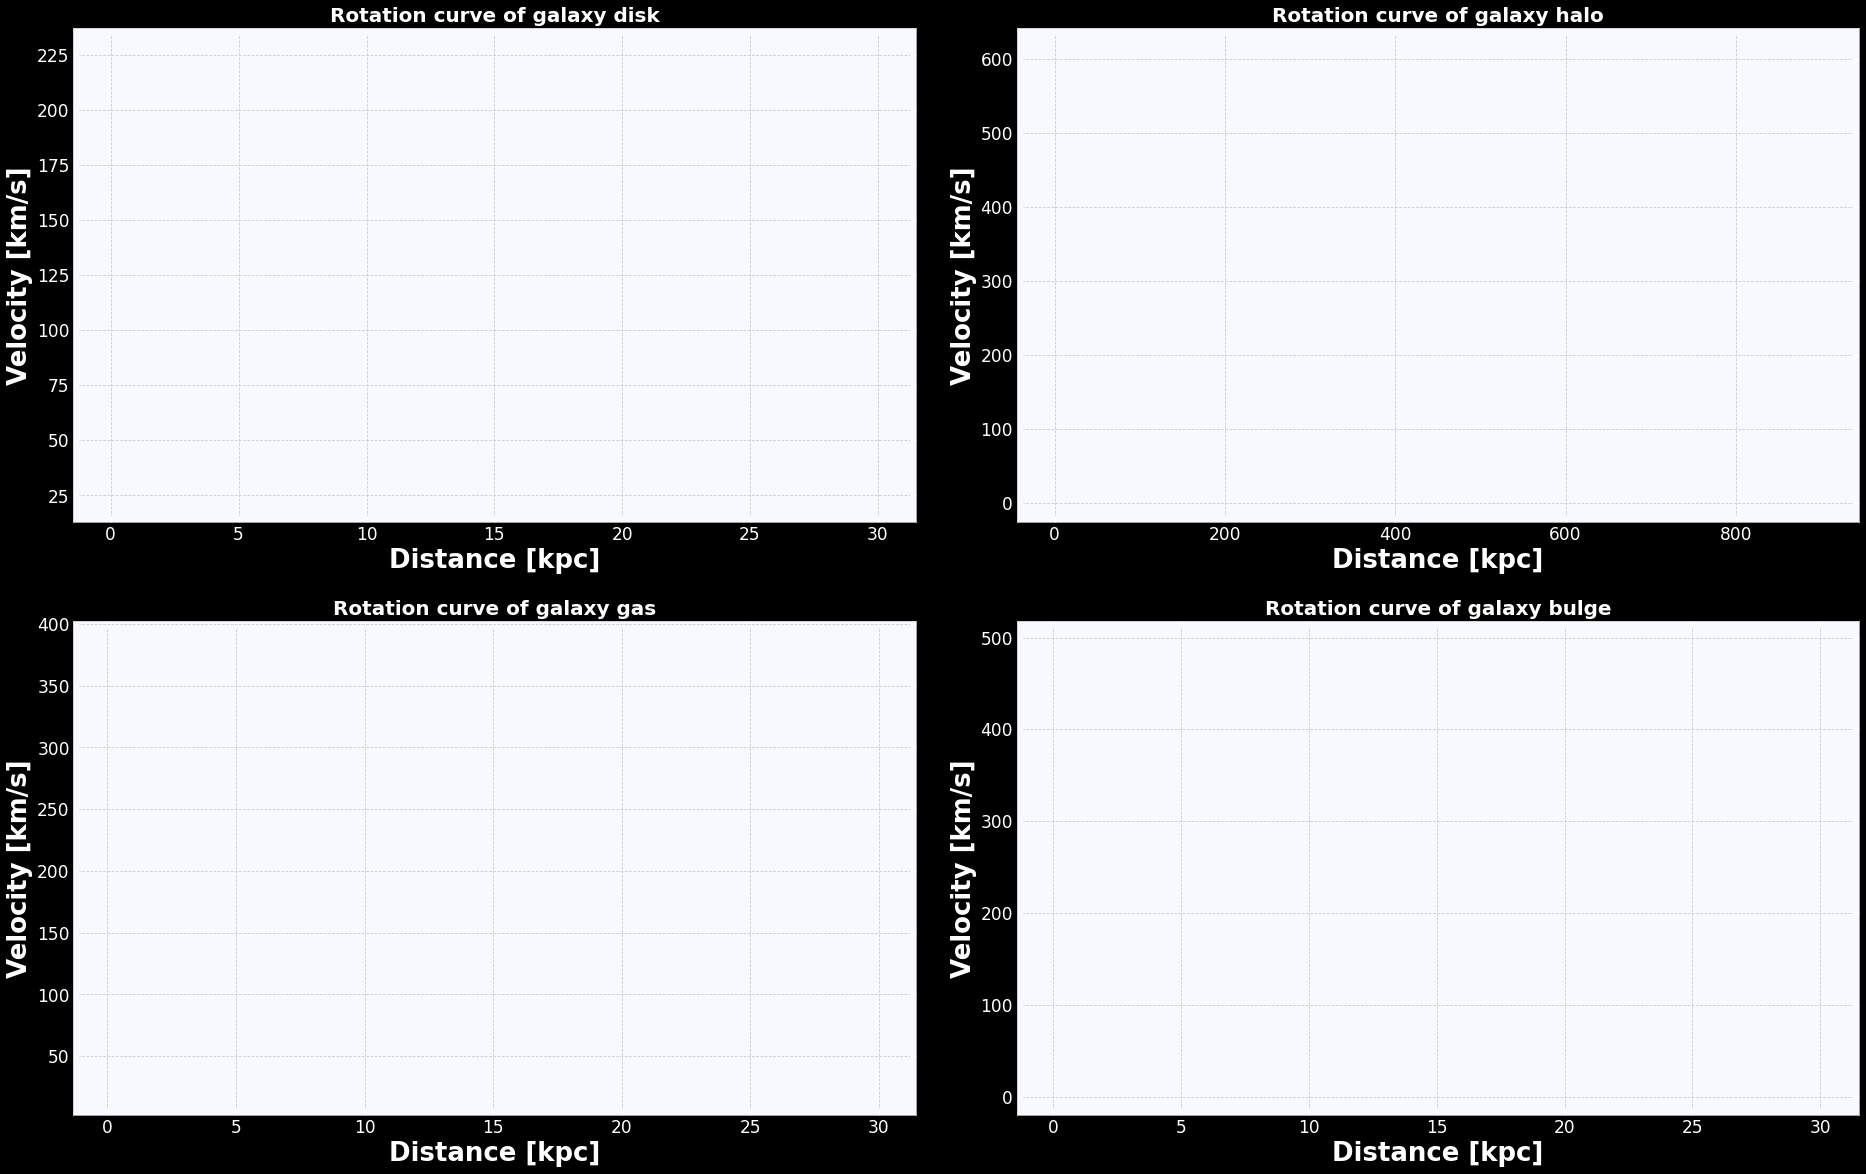

In [11]:
a = AnimeteRotationProfile(snapshots, fps=15)

In [12]:
a.ani.save('galaxy_rotation_profile_15fps.mp4', writer=a.writer)